In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('transactions.csv')

In [ ]:
#Checking information of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Transaction ID   1000 non-null   object 
 1   Timestamp        1000 non-null   object 
 2   Sender Name      1000 non-null   object 
 3   Sender UPI ID    1000 non-null   object 
 4   Receiver Name    1000 non-null   object 
 5   Receiver UPI ID  1000 non-null   object 
 6   Amount (INR)     1000 non-null   float64
 7   Status           1000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 62.6+ KB


In [4]:
df.head()

,Transaction ID,Timestamp,Sender Name,Sender UPI ID,Receiver Name,Receiver UPI ID,Amount (INR),Status
0,4d3db980-46cd-4158-a812-dcb77055d0d2,2024-06-22 04:06:38,Tiya Mall,4161803452@okaxis,Mohanlal Golla,7776849307@okybl,3907.34,FAILED
1,099ee548-2fc1-4811-bf92-559c467ca792,2024-06-19 06:04:49,Mohanlal Bakshi,8908837379@okaxis,Mehul Sankaran,7683454560@okaxis,8404.55,SUCCESS
2,d4c05732-6b1b-4bab-90b9-efe09d252b99,2024-06-04 04:56:09,Kismat Bora,4633654150@okybl,Diya Goel,2598130823@okicici,941.88,SUCCESS
3,e8df92ee-8b04-4133-af5a-5f412180c8ab,2024-06-09 09:56:07,Ayesha Korpal,7018842771@okhdfcbank,Rhea Kothari,2246623650@okaxis,8926.00,SUCCESS
4,e7d675d3-04f1-419c-a841-7a04662560b7,2024-06-25 08:38:19,Jivin Batta,1977143985@okybl,Baiju Issac,5245672729@okybl,2800.55,SUCCESS


In [5]:
df.describe()

,Amount (INR)
count,1000.000000
mean,4999.022930
std,2873.484534
min,28.520000
25%,2521.620000
50%,4951.435000
75%,7315.835000
max,9993.060000


In [ ]:


df['is_fraud'] = 0  

# Rule 1: High amount and failed status
df.loc[(df['Amount (INR)'] > 50000) & (df['Status'] == 'FAILED'), 'is_fraud'] = 1

# Rule 2: Odd hours (2AM to 4AM)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Convert Timestamp to datetime
df['Hour'] = df['Timestamp'].dt.hour
df.loc[df['Hour'].between(2, 4), 'is_fraud'] = 1

# Rule 3: Repeated transfers to the same receiver by the same sender within a short time
df['Sender_Receiver'] = df['Sender UPI ID'] + "_" + df['Receiver UPI ID']
df['Time_diff'] = df.groupby('Sender_Receiver')['Timestamp'].diff().dt.total_seconds().fillna(0)
df.loc[(df['Time_diff'] < 3600) & (df['Sender_Receiver'].duplicated(keep=False)), 'is_fraud'] = 1

# Rule 4: Mismatched UPI handles
df.loc[df['Sender UPI ID'].str.contains('@okhdfcbank') & df['Receiver UPI ID'].str.contains('@okyesbank'), 'is_fraud'] = 1


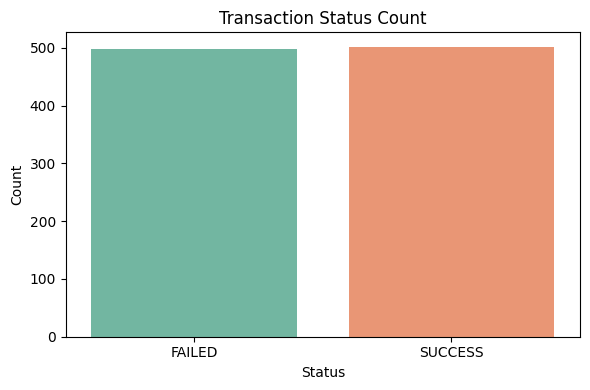

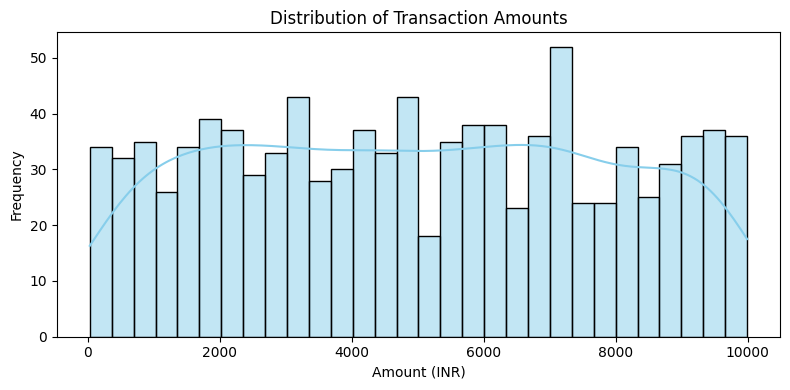

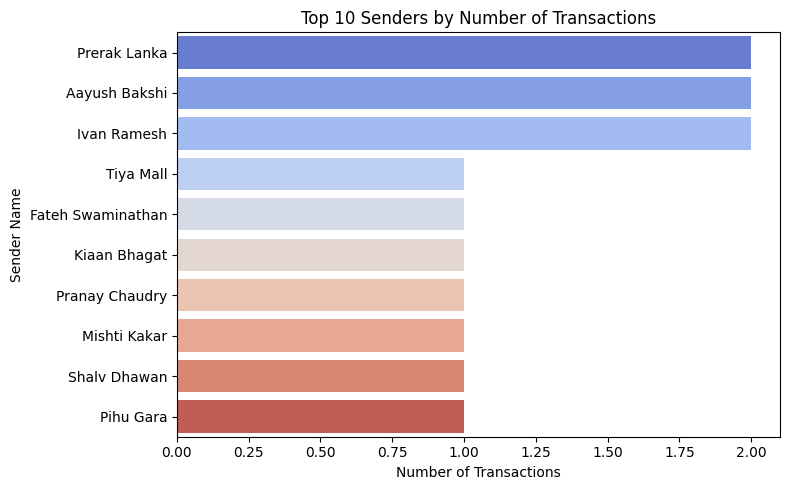

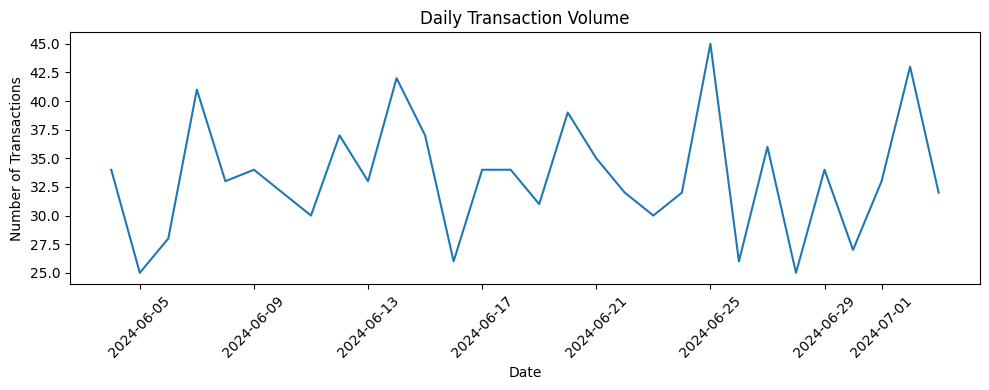

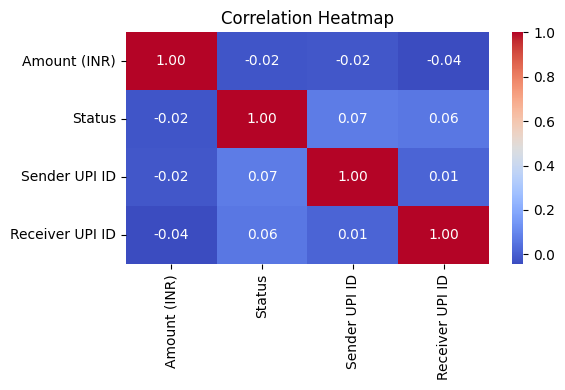

In [ ]:
# Converting Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# --- 1. Transaction Status Count ---
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Status', palette='Set2')
plt.title('Transaction Status Count')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# --- 2. Distribution of Transaction Amounts ---
plt.figure(figsize=(8, 4))
sns.histplot(df['Amount (INR)'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount (INR)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- 3. Top 10 Senders by Transaction Count ---
top_senders = df['Sender Name'].value_counts().nlargest(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_senders.values, y=top_senders.index, palette='coolwarm')
plt.title('Top 10 Senders by Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Sender Name')
plt.tight_layout()
plt.show()

# --- 4. Daily Transaction Volume Trend ---
daily_trend = df.groupby(df['Timestamp'].dt.date)['Transaction ID'].count()
plt.figure(figsize=(10, 4))
daily_trend.plot()
plt.title('Daily Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 5. Correlation Heatmap ---
# Encoding categorical columns for correlation
df_encoded = df.copy()
df_encoded['Status'] = df_encoded['Status'].map({'SUCCESS': 0, 'FAILED': 1})
df_encoded['Sender UPI ID'] = df_encoded['Sender UPI ID'].astype('category').cat.codes
df_encoded['Receiver UPI ID'] = df_encoded['Receiver UPI ID'].astype('category').cat.codes

# Selecting only numeric columns
numeric_cols = df_encoded[['Amount (INR)', 'Status', 'Sender UPI ID', 'Receiver UPI ID']]

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [ ]:


#  Converting Timestamp to datetime and extract features 
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

#  Dropping irrelevant text columns 
df = df.drop(['Transaction ID', 'Sender Name', 'Receiver Name'], axis=1)

#  Encoding categorical columns (UPI IDs and Status) 
le_sender = LabelEncoder()
le_receiver = LabelEncoder()
df['Sender UPI ID'] = le_sender.fit_transform(df['Sender UPI ID'])
df['Receiver UPI ID'] = le_receiver.fit_transform(df['Receiver UPI ID'])

# Converting status to binary
df['Status'] = df['Status'].map({'SUCCESS': 0, 'FAILED': 1})

#  Normalize Amounting
scaler = StandardScaler()
df['Amount (INR)'] = scaler.fit_transform(df[['Amount (INR)']])

# Drop Timestamp 
df = df.drop(['Timestamp'], axis=1)

#  Splitting into Features and Target 
# Drop the problematic string column
X = df.drop(['Sender_Receiver', 'is_fraud'], axis=1)
y = df['is_fraud']





Logistic Regression Metrics:
Accuracy: 0.8366666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       266
           1       0.24      0.21      0.22        34

    accuracy                           0.84       300
   macro avg       0.57      0.56      0.57       300
weighted avg       0.83      0.84      0.83       300



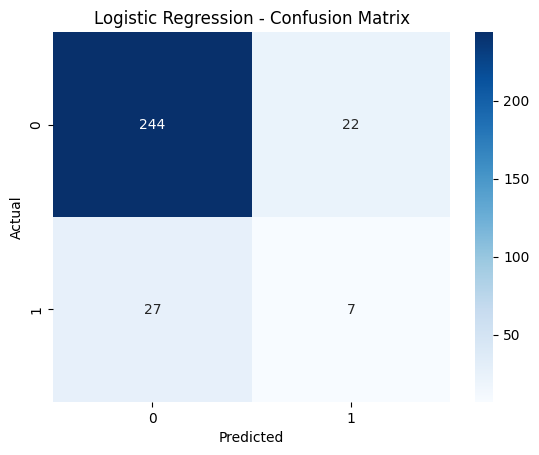


Support Vector Machine Metrics:
Accuracy: 0.8866666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       266
           1       0.00      0.00      0.00        34

    accuracy                           0.89       300
   macro avg       0.44      0.50      0.47       300
weighted avg       0.79      0.89      0.83       300



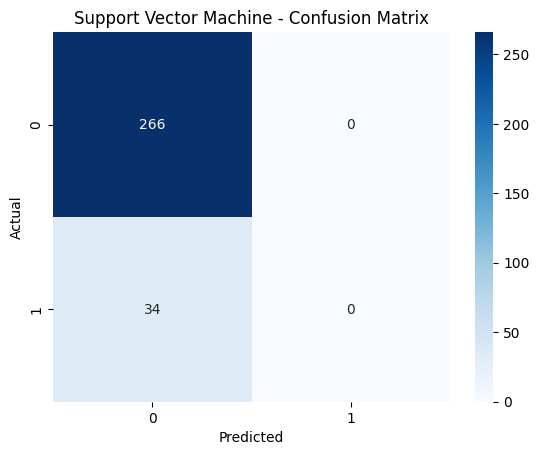


AdaBoost Metrics:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00        34

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



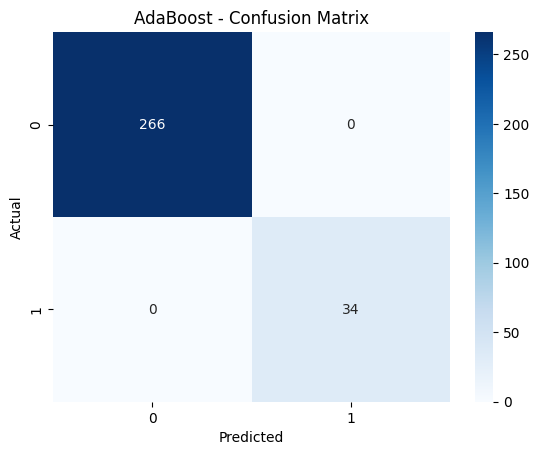


ROC-AUC Scores:
Logistic Regression: 0.90734188412207
SVM: 0.8815789473684211
AdaBoost: 1.0


In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------
# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# ---------------------
# 2. Support Vector Machine
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# ---------------------
# 3. AdaBoost Classifier
adb = AdaBoostClassifier(n_estimators=100)
adb.fit(X_train, y_train)
y_pred_adb = adb.predict(X_test)

# ---------------------
# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Metrics:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ---------------------
#  Evaluations
evaluate_model("Logistic Regression", y_test, y_pred_logreg)
evaluate_model("Support Vector Machine", y_test, y_pred_svm)
evaluate_model("AdaBoost", y_test, y_pred_adb)

# ---------------------
# ROC-AUC Scores
print("\nROC-AUC Scores:")
print("Logistic Regression:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))
print("SVM:", roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1]))
print("AdaBoost:", roc_auc_score(y_test, adb.predict_proba(X_test)[:, 1]))


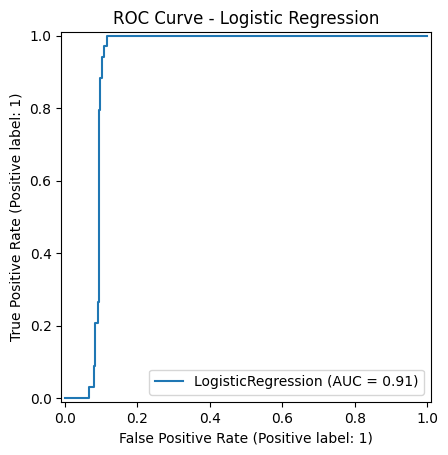

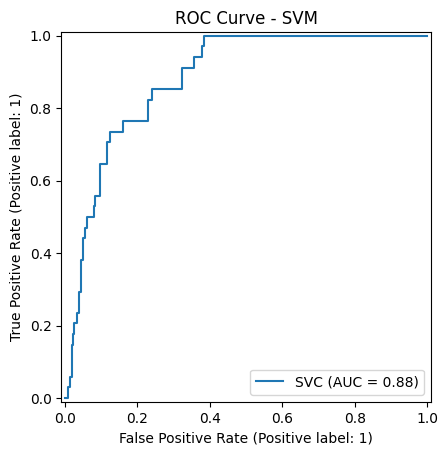

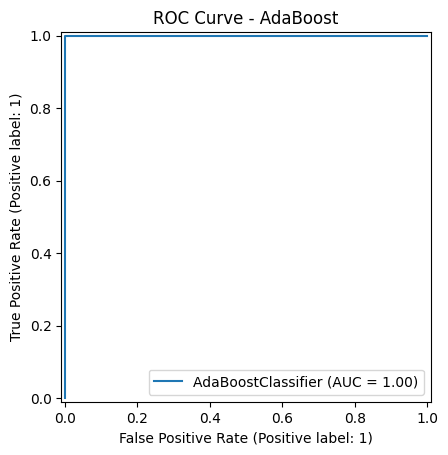

In [31]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

RocCurveDisplay.from_estimator(svm, X_test, y_test)
plt.title("ROC Curve - SVM")
plt.show()

RocCurveDisplay.from_estimator(adb, X_test, y_test)
plt.title("ROC Curve - AdaBoost")
plt.show()
